# Moody Diagram Generation

As a fluid flows through a pipe, it encounters resistance according to several factors, including the
diameter and wall roughness of the pipe, the velocity and viscosity of the fluid, and whether the
fluid is in a laminar or turbulent state. However, the relationship between these variables is typically
complex and nonlinear, meaning that we require computational techniques to predict pressure losses
– a requirement in a range of engineering design scenarios.
The purpose of this assignment is to create a predictive engineering tool to calculate the so-called friction factor of a pipe flow, thereby providing an estimate of pressure loss per unit length.

## Theroy

Consider a circular pipe of diameter D and length L, through which a fluid of density ρ is flowing at a
mean flow velocity U. The pressure loss ∆p per unit length is given by the Darcy-Weisbach equation:

$$ \frac{∆p}{L} = fD\frac{ρU^{2}}{2D} $$

where the dimensionless quantity fD is referred to as the Darcy friction factor. The value of fD,
however, is difficult to determine for turbulent flows, as it depends on the Reynolds number:

$$ Re = \frac{ρUD}{μ} $$

where μ is the dynamic viscosity of the fluid. Re dictates whether the fluid is in a turbulent or
laminar state: if Re < 2040 the flow can be assumed to be laminar, or if Re ≥ 2040 we assume
it is turbulent.

For turbulent flows, the pipe’s relative roughness, $ εr = ε/D $, where ε is the pipe’s effective
roughness height.




## Calculating $fD$

If the flow is laminar, then the relationship for the friction factor is straightforward and can be derived
from the Poiseuille (laminar) flow profile, giving

$$ fD = \frac{64}{Re} $$

On the other hand, if the flow is turbulent, the relationship is more complex. In this case, fD can only
be found by solving the nonlinear Colebrook-White equation

$$ \frac{1}{√fD} = −2\log_{10}( \frac{2.51}{Re√fD}  + \frac{ε/D}{3.72} ) $$

Clearly, this relationship cannot be solved analytically. However, by rearranging this equation, we
can see that it can instead be turned into a root-finding problem; i.e. find $fD$ such that the function
$C(fD) = 0$, where

$$ C(fD) = \frac{1}{√fD} + 2\log_{10}(\frac{2.51}{Re√fD} + \frac{ε/D}{3.72}) $$

This then becomes a root finding problem which can be resolved with the implimentation of a Newton-Rapshon solver. We can first begin by defining $C(fD)$ as a function.

In [1]:
def colebrook(fD , Re , epsD):
    return((1/np.sqrt(fD)) + 2*(np.log10((2.51/(Re*np.sqrt(fD)))+(epsD/3.72))))

We can then create a function for the derivative of the rearanged Colebrook Equation

In [2]:
def colebrook_deriv(fD , Re , epsD):
    return(-(251/(100 * np.log(10) * Re * (fD ** (3/2)) * ((2.51/100*np.sqrt(fD))+((25 * epsD)/93)))) - (1/(2 * (fD ** (3/2)))))

Newton function to perform Newton Raphson and itterate to a suitable solution to a given tollerence

In [8]:
def newton(x0 , Re , epsD , maxiter=100 , tol=1e-09):
    for i in range(maxiter - 1): #only iterating as far as specified maxiter
        x1 = x0 - (colebrook(x0 , Re , epsD)/colebrook_deriv(x0 , Re , epsD))
        if abs(x0 - x1) < tol:
            break   #break if specified tollerance is met
        else :
            x0 = x1
    return(x1,i+1)


Moody function which will generate Moody Diagram for given points and various turbulent flows

In [9]:
def moody(filename , points):
    #Generating points for Laminar plot
    ReLam = np.linspace(500 , 2500 , 5)
    laminar = 64/ReLam
    plt.plot(ReLam , laminar , label = "laminar")   #Plot points to Moody

    #Generating points for varying values of epsilonD
    epsilonD = [1e-02 , 1e-03 , 1e-04 , 1e-05 , 1e-06]
    Re = np.logspace(np.log10(2000) , 8 , 50)
    fD = []
    for i in epsilonD :
        fDi = []
        for a in Re:
            fDi.append(newton(x0 , a , i , maxiter , tol)[0])   #Generate list of fD values for given epsilonD
        fD.append(fDi)  #Append to nested list of all fD values for rough pipes

    for b in range(len(epsilonD)):
        lab = r'$\epsilon / D$' + '=1e-0' + str(b+2)
        plt.plot(Re , fD[b] , label=lab)    #Plot values for rough pipes to Moody

    #Generating values for smooth pipe
    smooth=[]
    for d in Re :
        smooth.append(newton(x0 , d , 0 , maxiter , tol)[0])
    plt.plot(Re , smooth , label='smooth')  #Plot smooth turbulent pipe to moody

    #Generating values for straight line marking transition between Laminar and Turbulent
    transition = [2000 for x in range(5)]
    y = np.linspace(0.005 , 0.13 , 5)
    plt.plot(transition , y , 'r' , linestyle='--' , label = 'transition')

    #Plotting supplied points from nested list
    Revals = [p[0] for p in points]
    fricfac = [p[1] for p in points]
    plt.plot(Revals , fricfac , 'xk' , markersize=5, label='points')

    #Moody Diagram Annotation
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(which='both' , axis='both' , linestyle='--')

    plt.legend(loc=3 , prop={'size':7})
    plt.title('Moody Diagram for Laminar/Turbulent Pipe Flow')
    plt.xlabel('Reynolds Number Re')
    plt.ylabel('Friction Factor ' + r'$f_D$')
    plt.savefig(filename + '.pdf')
    plt.show()

Defining Initial Conditions

In [10]:
import numpy as np
import matplotlib.pyplot as plt

class Error(Exception):     #Creating class of user defined exceptions
    pass

class NoCovergenceError(Error):     #Exception for no convergenec on Newton Raphson
    """Exception raised for maxiter reached in Newton."""
    pass

x0 = 0.001            #initial guess for Newton Raphson itteration
maxiter = 100          #max number of Newton Raphson itterations
tol = 1e-09             #tollerance to stop itterating Newton Raphson

## Script to Solve for Supplied Input Points

Please enter the txt file containing input data or press n to exit: input

Sorry file does not exist.

Please enter the txt file containing input data or press n to exit: inputs


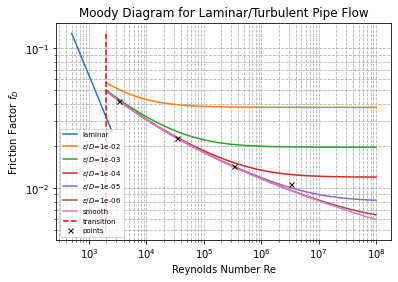

In [11]:
while True:
    readfile = input('Please enter the txt file containing input data or press n to exit: ') + ('.txt')    #Taking input file of given data

    if readfile == 'n.txt':
        break
    else:
        try:
            data = np.loadtxt(readfile)     #Opening supplied data input file
            nopoint = data.shape[0]         #Finding the number of supplied points

            if data.shape[1] != 5:
                raise ValueError

            points = []
            ploverl = []
            for i in range(nopoint):        #Loop over all points
                Re = (data[i,0]*data[i,1]*data[i,2])/data[i,3]                              #Calculate Re from data
                fricfac = newton(x0 , Re , (data[i,4]/data[i,0])*1e-3 , maxiter , tol)      #Calculate fD from data
                points.append([Re , fricfac[0]])                                            #Generate points

                ploverl.append([fricfac[0] , fricfac[0]*((data[i,2]*data[i,1]**2)/(2*data[i,0]))])  #Calculate losses and add to array


                if fricfac[1] == (maxiter-1):   #Raising error for no convergence
                    raise NoCovergenceError

            np.savetxt('losses.txt' , ploverl)      #write array to txt file

            moody('moody' , points)      #Plot Moody Diagram using function
            break

        except ValueError:  #Not allowing data that contains anything other than numeric values
            print('\nSorry, file contains invalid data. Please try again.\n')

        except IOError:   #Not allowing files that do not exist
            print('\nSorry file does not exist.\n')
        except NoCovergenceError:   #Error if Newton Raphson doesn't converge
            print('\nNewton Raphson did not converge to a solution of fD within the given tollerance for the supplied points.\n')